Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing all the important libraries

In [2]:
import pathlib
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping


In [ ]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
# Defining the path for train and test images

base_path = '/content/drive/MyDrive/CNNAssignment'
data_dir_train = pathlib.Path(base_path + '/Train')
data_dir_test = pathlib.Path(base_path + '/Test')

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2249
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

---



In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2249 files belonging to 9 classes.
Using 1800 files for training.


In [11]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size)

Found 2249 files belonging to 9 classes.
Using 449 files for validation.


In [12]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

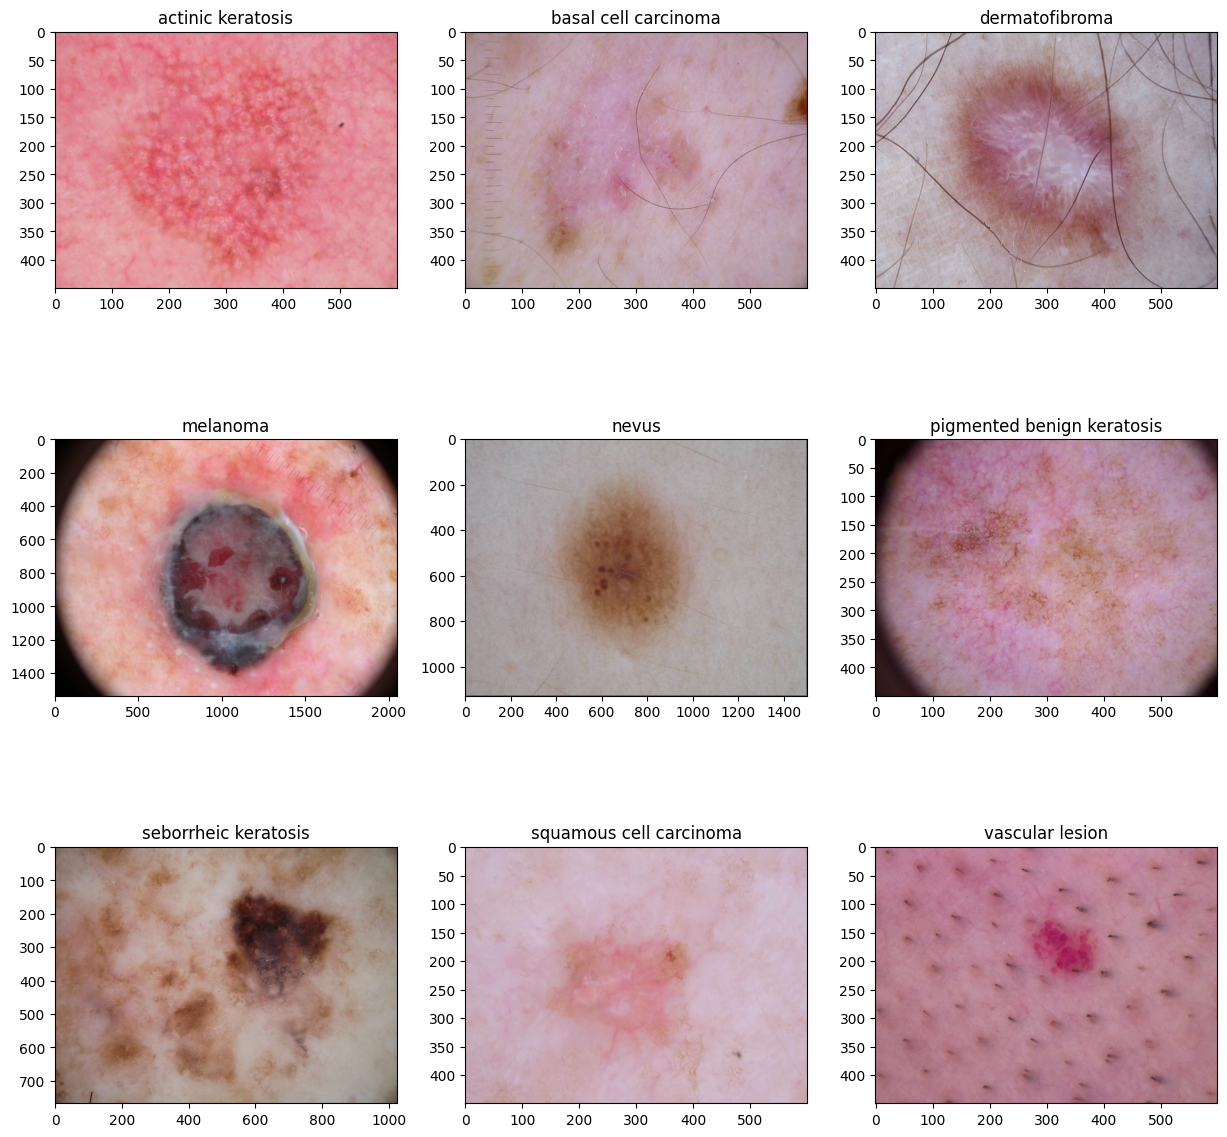

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))

for i in range(len(class_names)):
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
### Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = len(class_names)
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [16]:
### Todo, choose an appropirate optimiser and loss function

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                   

### Train the model

In [18]:

# Train the model
epochs = 20
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


57/57 [==============================] - 404s 1s/step - loss: 2.0578 - accuracy: 0.1961 - val_loss: 2.0312 - val_accuracy: 0.1960
Epoch 2/20
57/57 [==============================] - 5s 89ms/step - loss: 2.0024 - accuracy: 0.2389 - val_loss: 1.8414 - val_accuracy: 0.3608
Epoch 3/20
57/57 [==============================] - 5s 90ms/step - loss: 1.9108 - accuracy: 0.2661 - val_loss: 1.9004 - val_accuracy: 0.2628
Epoch 4/20
57/57 [==============================] - 5s 88ms/step - loss: 1.8100 - accuracy: 0.3422 - val_loss: 1.7171 - val_accuracy: 0.3942
Epoch 5/20
57/57 [==============================] - 5s 89ms/step - loss: 1.6543 - accuracy: 0.4022 - val_loss: 1.6782 - val_accuracy: 0.3697
Epoch 6/20
57/57 [==============================] - 5s 89ms/step - loss: 1.5663 - accuracy: 0.4439 - val_loss: 1.5821 - val_accuracy: 0.4566
Epoch 7/20
57/57 [==============================] - 5s 89ms/step - loss: 1.5347 - accuracy: 0.4539 - val_loss: 1.5581 - val_accuracy: 0.4410
Epoch 8/20
57/57 [======

### Visualizing training results

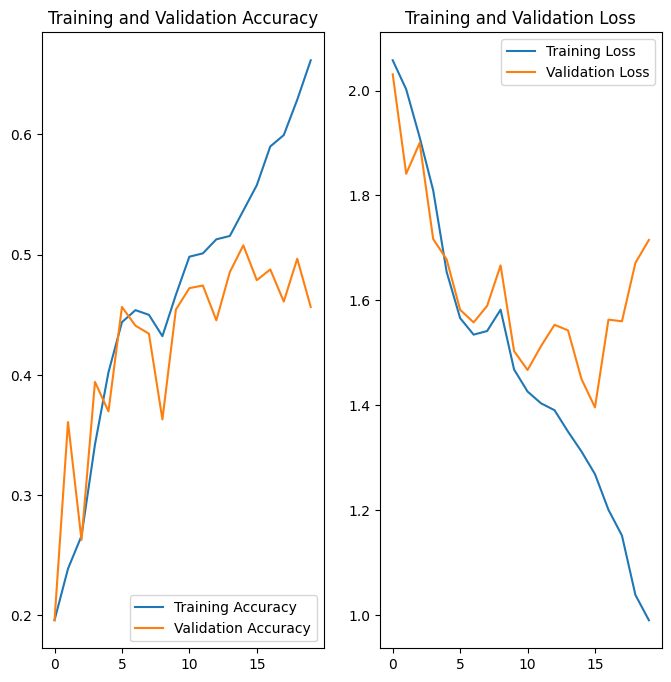

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

In [20]:

loss_t, accuracy_t = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy_t)
print("Loss: ",loss_t)
print("Validation Accuracy: ",accuracy_v)
print("Validation Loss", loss_v)

15/15 [==============================] - 0s 21ms/step - loss: 1.7153 - accuracy: 0.4566
Accuracy:  0.6227777600288391
Loss:  1.038184642791748
Validation Accuracy:  0.4565701484680176
Validation Loss 1.7152873277664185


### Write your findings here

##### Training acccuracy is 62%, while validation accuracy is 45%.
##### Training accuracy greatly surpasses validation. accuracy. This is a clear indication of model overfitting.

##### Training loss is also less as compared to validation loss. It also indicates that the model is overfitting.


In [21]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

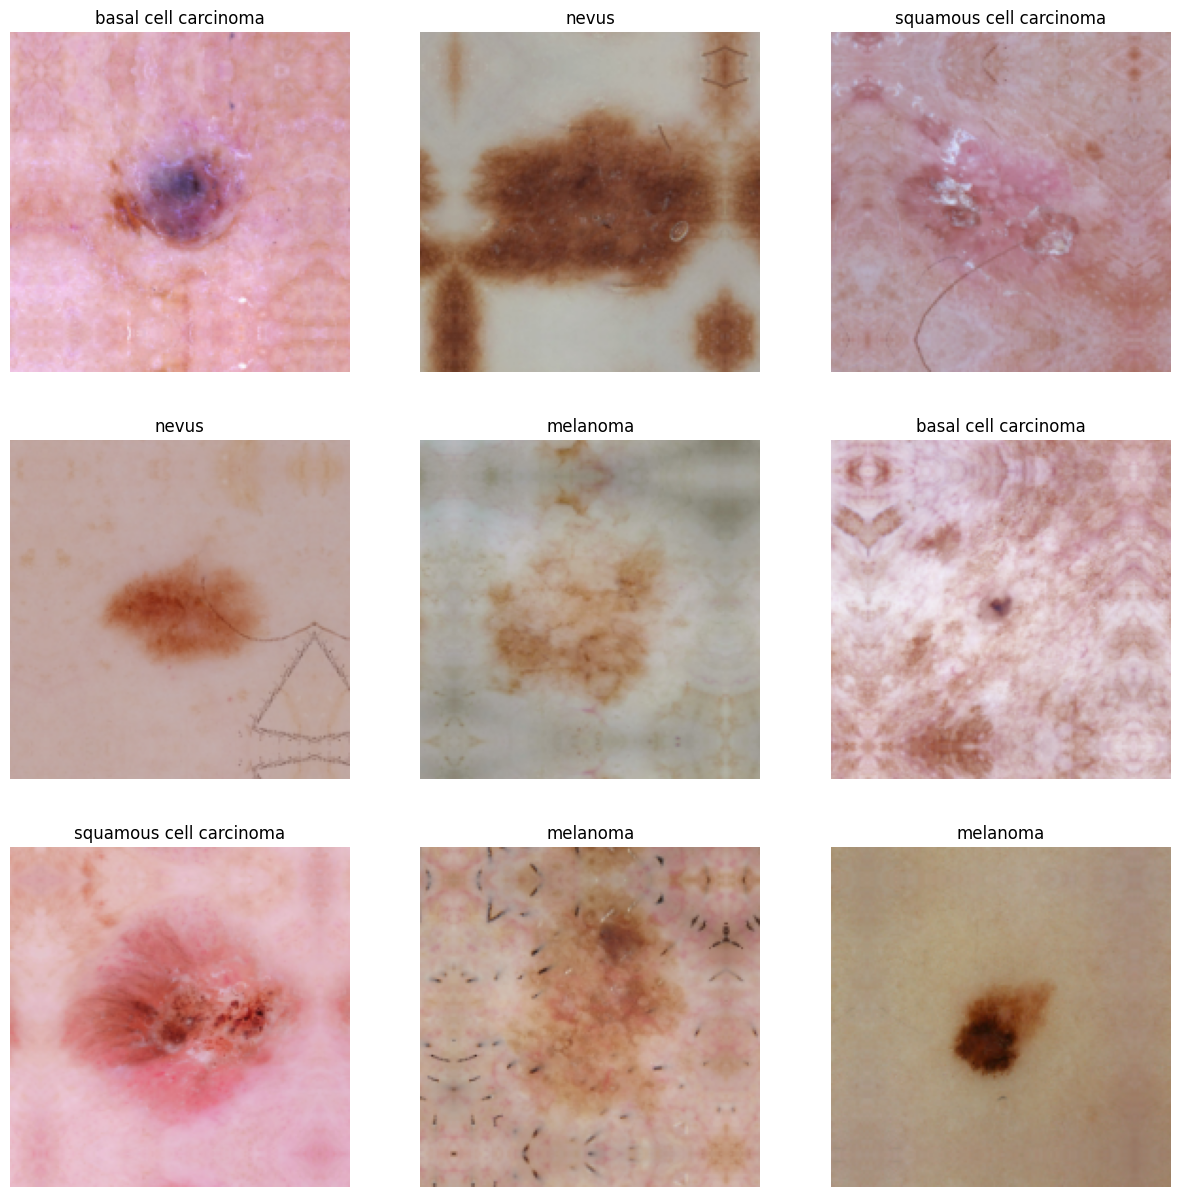

In [22]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [23]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = len(class_names)
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))



### Compiling the model

In [24]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [25]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 10s 119ms/step - loss: 2.0779 - accuracy: 0.1922 - val_loss: 2.0496 - val_accuracy: 0.1960
Epoch 2/20
57/57 [==============================] - 6s 103ms/step - loss: 2.0398 - accuracy: 0.1911 - val_loss: 2.0331 - val_accuracy: 0.1960
Epoch 3/20
57/57 [==============================] - 6s 103ms/step - loss: 2.0226 - accuracy: 0.2056 - val_loss: 2.0370 - val_accuracy: 0.1960
Epoch 4/20
57/57 [==============================] - 6s 103ms/step - loss: 2.0202 - accuracy: 0.1950 - val_loss: 2.0338 - val_accuracy: 0.1915
Epoch 5/20
57/57 [==============================] - 6s 99ms/step - loss: 2.0524 - accuracy: 0.1856 - val_loss: 2.0351 - val_accuracy: 0.1492
Epoch 6/20
57/57 [==============================] - 6s 101ms/step - loss: 2.0190 - accuracy: 0.2078 - val_loss: 2.0342 - val_accuracy: 0.1960
Epoch 7/20
57/57 [==============================] - 6s 102ms/step - loss: 2.0180 - accuracy: 0.2039 - val_loss: 2.0285 - val_accuracy: 0.1960
Epoch 

### Visualizing the results

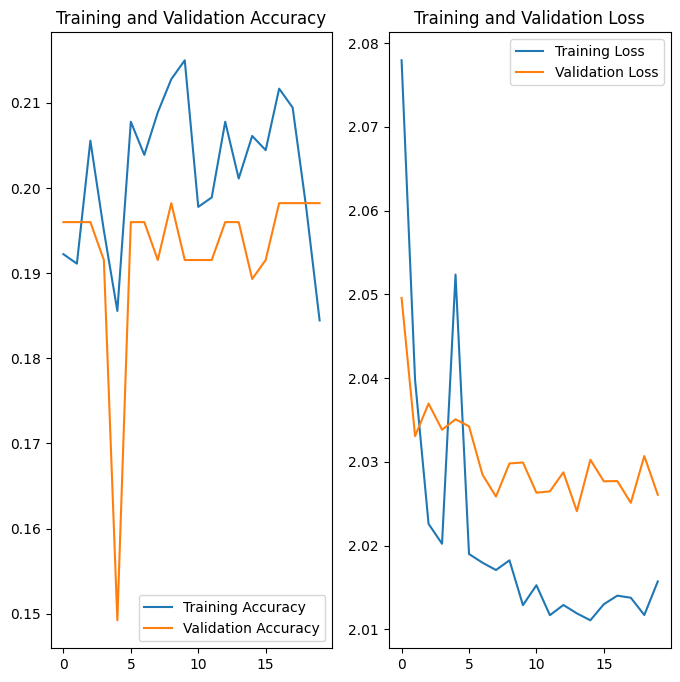

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:

loss_t, accuracy_t = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy_t)
print("Loss: ",loss_t)
print("Validation Accuracy: ",accuracy_v)
print("Validation Loss", loss_v)

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?



1.   Training and validation accuracy has dropped, but they are in very close approximation with each other ranging between 18%-20%.
2.   With increased epochs, both the training and validation losses have come down.
3. This model is showing some symptomps of underfitting.



#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [28]:
## Your code goes here.
path_list=[]
lesion_list=[]
for i in class_names:

    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/CNNAssignment/Train/act...,actinic keratosis
1,/content/drive/MyDrive/CNNAssignment/Train/act...,actinic keratosis
2,/content/drive/MyDrive/CNNAssignment/Train/act...,actinic keratosis
3,/content/drive/MyDrive/CNNAssignment/Train/act...,actinic keratosis
4,/content/drive/MyDrive/CNNAssignment/Train/act...,actinic keratosis
...,...,...
2244,/content/drive/MyDrive/CNNAssignment/Train/vas...,vascular lesion
2245,/content/drive/MyDrive/CNNAssignment/Train/vas...,vascular lesion
2246,/content/drive/MyDrive/CNNAssignment/Train/vas...,vascular lesion
2247,/content/drive/MyDrive/CNNAssignment/Train/vas...,vascular lesion


In [29]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df


,Path,Label
0,/content/drive/MyDrive/CNNAssignment/Train/act...,actinic keratosis
1,/content/drive/MyDrive/CNNAssignment/Train/act...,actinic keratosis
2,/content/drive/MyDrive/CNNAssignment/Train/act...,actinic keratosis
3,/content/drive/MyDrive/CNNAssignment/Train/act...,actinic keratosis
4,/content/drive/MyDrive/CNNAssignment/Train/act...,actinic keratosis
...,...,...
2244,/content/drive/MyDrive/CNNAssignment/Train/vas...,vascular lesion
2245,/content/drive/MyDrive/CNNAssignment/Train/vas...,vascular lesion
2246,/content/drive/MyDrive/CNNAssignment/Train/vas...,vascular lesion
2247,/content/drive/MyDrive/CNNAssignment/Train/vas...,vascular lesion


<BarContainer object of 9 artists>

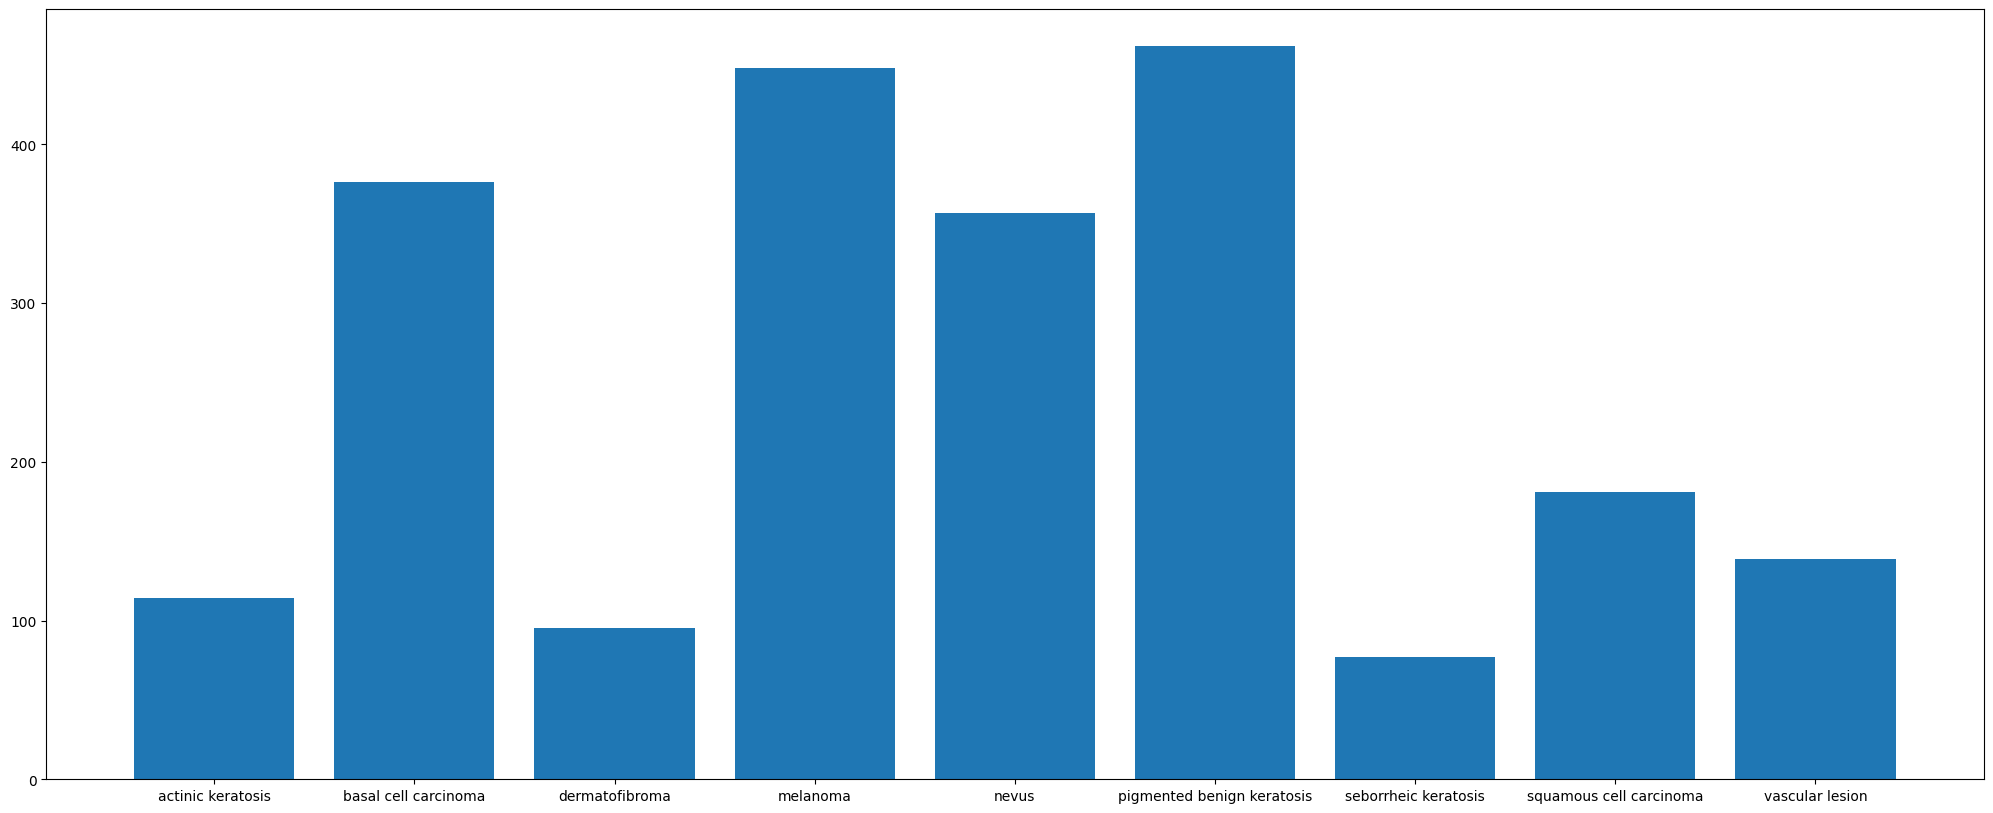

In [30]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
##### Answer: seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
##### Answer: pigmented benign keratosis & melanoma

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [31]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [32]:
output_dir = base_path + "/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(output_dir + i, save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNNAssignment/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D20AA19D540>: 100%|██████████| 500/500 [00:22<00:00, 22.10 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNNAssignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D20AA19F550>: 100%|██████████| 500/500 [00:25<00:00, 19.86 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNNAssignment/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D21004EC250>: 100%|██████████| 500/500 [00:19<00:00, 25.26 Samples/s]


Initialised with 448 image(s) found.
Output directory set to /content/drive/MyDrive/CNNAssignment/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7D21202BA050>: 100%|██████████| 500/500 [01:25<00:00,  5.85 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNNAssignment/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7D209FF42590>: 100%|██████████| 500/500 [01:10<00:00,  7.10 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNNAssignment/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D21202829E0>: 100%|██████████| 500/500 [00:18<00:00, 27.14 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNNAssignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D209FE31960>: 100%|██████████| 500/500 [00:43<00:00, 11.46 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNNAssignment/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D21202BA680>: 100%|██████████| 500/500 [00:18<00:00, 27.74 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNNAssignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D2120447BE0>: 100%|██████████| 500/500 [00:18<00:00, 26.67 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [33]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [35]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/CNNAssignment/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026313.jpg_d2aa05ef-89fe-4575-8771-0138a9a628d6.jpg',
 '/content/drive/MyDrive/CNNAssignment/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033790.jpg_1be1b823-93f1-4316-bcab-59ab851dc6ef.jpg',
 '/content/drive/MyDrive/CNNAssignment/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025302.jpg_9dc1b611-95bd-4581-9158-7d46f68edc39.jpg',
 '/content/drive/MyDrive/CNNAssignment/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026417.jpg_c2a02153-767e-4828-bfce-220b6030b1d0.jpg',
 '/content/drive/MyDrive/CNNAssignment/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029578.jpg_4c072c08-a6fc-4c53-8285-ea621789259d.jpg',
 '/content/drive/MyDrive/CNNAssignment/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033780.jpg_97928cb5-2926-4342-a21d-d35ea276f995.jpg',
 '/content/drive/MyDrive/CNNAssignment/Train/dermatofibroma/output/dermatofibroma_original_ISI

In [36]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [37]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [38]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [39]:
new_df['Label'].value_counts()

Label
dermatofibroma                500
seborrheic keratosis          500
vascular lesion               500
squamous cell carcinoma       500
melanoma                      500
pigmented benign keratosis    500
actinic keratosis             500
basal cell carcinoma          500
nevus                         500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [40]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [41]:
data_dir_train=base_path + '/Train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 5400 files for training.


#### **Todo:** Create a validation dataset

In [42]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 1349 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [43]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [44]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [45]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 50s 274ms/step - loss: 2.1588 - accuracy: 0.1489 - val_loss: 2.1999 - val_accuracy: 0.1438
Epoch 2/50
169/169 [==============================] - 44s 249ms/step - loss: 2.0459 - accuracy: 0.2107 - val_loss: 1.9785 - val_accuracy: 0.2187
Epoch 3/50
169/169 [==============================] - 44s 254ms/step - loss: 1.9099 - accuracy: 0.2594 - val_loss: 1.8844 - val_accuracy: 0.2721
Epoch 4/50
169/169 [==============================] - 47s 270ms/step - loss: 1.7358 - accuracy: 0.3481 - val_loss: 1.8015 - val_accuracy: 0.3062
Epoch 5/50
169/169 [==============================] - 44s 252ms/step - loss: 1.5149 - accuracy: 0.4343 - val_loss: 1.4439 - val_accuracy: 0.4804
Epoch 6/50
169/169 [==============================] - 44s 251ms/step - loss: 1.2659 - accuracy: 0.5435 - val_loss: 1.3222 - val_accuracy: 0.4989
Epoch 7/50
169/169 [==============================] - 43s 248ms/step - loss: 1.0660 - accuracy: 0.6144 - val_loss: 1.2759 - val_accuracy: 0.5

#### **Todo:**  Visualize the model results

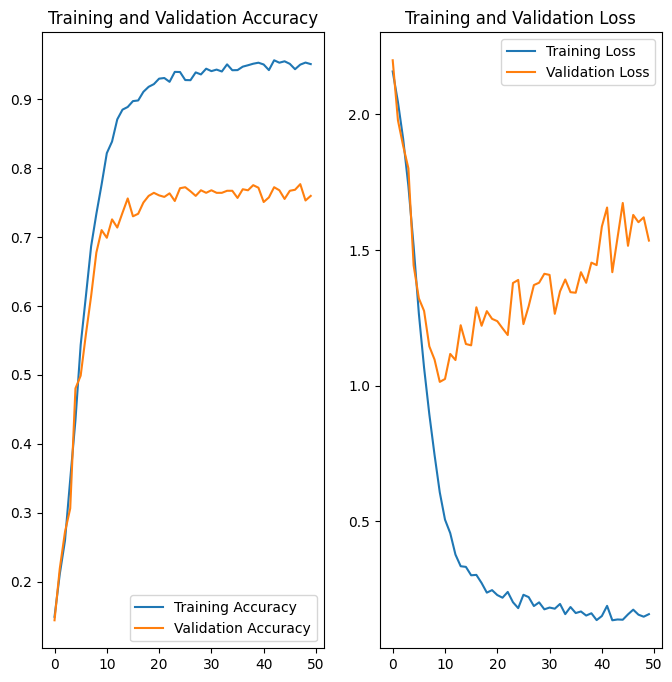

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [47]:
loss_tf, accuracy_tf = model.evaluate(train_ds, verbose=1,)
loss_vf, accuracy_vf = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy_tf)
print("Loss: ",loss_tf)
print("Validation Accuracy: ",accuracy_vf)
print("Validation Loss", loss_vf)

43/43 [==============================] - 8s 170ms/step - loss: 1.5352 - accuracy: 0.7598
Accuracy:  0.9551851749420166
Loss:  0.16792020201683044
Validation Accuracy:  0.7598220705986023
Validation Loss 1.535194993019104


#### Observation

1.   Accuracy on training data has increased by using Augmentor library.
2.   Accuracy on validation data has also improved.
3. Validation losses are very high as compared to training losses.
4. There is a gap fo 20% in training accuracy and validation accuracy.

#### Conclusion

1.   The final model still is overfitting.
2.   Overfitting can be addressed by training the model on a larger dataset.
3.   Model's performance may also improve by hyperparameter tuning.




